<a href="https://colab.research.google.com/github/MahuL88/SpecialSkill/blob/main/Adult_Census_Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project kali ini adalah memprediksi apakah seseorang memiliki penghasilan lebih dari $50.000 per tahun berdasarkan berbagai fitur seperti usia, pendidikan, pekerjaan, status pernikahan, jam kerja mingguan, dan latar belakang demografis lainnya.

Proyek ini saya kaitkan dengan SDGs nomor 8 (Decent Work and Economic Growth) karena dapat membantu mengidentifikasi pola-pola ketimpangan ekonomi dan membuka peluang untuk analisis lebih lanjut terhadap faktor-faktor yang mempengaruhi kesenjangan pendapatan di masyarakat.

Saya menggunakan model supervised(XGBoost) dan unsupervised (K-Means Clustering dan PCA (Principal Component Analysis) untuk mereduksi dimensi dan memvisualisasikan distribusi serta struktur data secara lebih mudah dipahami) untuk dataset ini.

Source : [Adult Census Income](https://www.kaggle.com/datasets/uciml/adult-census-income)

# *Unsupervised Learning*

## Load & Eksplorasi Data

In [ ]:
# Impor library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Untuk Supervised
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Untuk Unsupervised
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load data ke sebuah dataframe bernama Adult Census Income (ACI)
aci = pd.read_csv('/content/adult.csv')

In [ ]:
# Melihat jumlah kolom dan baris(terdapat 15 kolom dan 32561 data)
aci.shape

(32561, 15)

In [ ]:
#cek detail informasi kolom (tidak ada missing value)
aci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# Melihat table secara garis besar dan tipe data(sudah sesuai seperti sebelumnya, namun bisa diperhatikan terdapat tanda (?) pada beberapa kolom)
aci.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
# Mengecek kolom mana yang terdapat tanda "?", terlihat bahwa kolom workclass, occupation, dan native.country yang memiliki tanda "?"
question_counts = aci.apply(lambda col: col.astype(str).str.count(r'\?').sum())
print(question_counts)

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [ ]:
# Analisis Statistik dasar (terlihat tidak ada nilai outlier)
aci.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
#Cek banyak baris yang terduplikat(terlihat ada 24 data duplikat)
aci.duplicated().sum()

np.int64(24)

### Kesimpulan

Dari hasil eksplorasi ini, ditemukan data yang duplikat sebanyak 24 data, tidak ada missing value, namun terdapat tanda (?) pada beberapa kolom. karena tidak ada kejelasan terkait hal ini serta hanya berjumlah 1K saja dan jumlah seluruh data berjumlah 30K, saya akan menghapus kolom yang memiliki tanda (?). untuk  tipe datanya sudah sesuai format, dan untuk kolom education akan dihapus karena sudah di encoding pada kolom education.num serta kolom fnlwgt dan race yang tidak terlalu penting dan pengaruh terhadap model

## Preprocessing

In [ ]:
# Hapus data duplikat dan indexnya akan direset
aci = aci.drop_duplicates().reset_index(drop = True)

In [ ]:
# Menghapus baris yang mengandung (?)
kategori_hapus = '?'

# Kolom yang dicek
kolom_cek = ['workclass', 'occupation', 'native.country']

# Hapus baris tersebut
aci =aci[~aci[kolom_cek].isin([kategori_hapus]).any(axis=1)]

In [ ]:
# Melihat kembali jumlah kolom dan baris(sekarang menjadi 15 kolom dan 30139 data)
aci.shape

(30139, 15)

In [ ]:
# Encode target variable 'income' menjadi biner:
# Jika income >50K diberi label 1, jika <=50K diberi label 0
aci['income'] = aci['income'].apply(lambda x: 1 if x == '>50K' else 0)

### Feature Engineering

Sebelum melakukan One-hot encoding, dilakukan feature engineering karena one-hot encoding ini akan menambahkan kolom baru dari setiap kategori, sehingga akan menyebabkan *Dimensionality Curse* yang mengakibatkan model jadi lambat dan rawan *overfitting*, sehingga :

In [ ]:
# Menghapus kolom yang tidak penting untuk prediksi (fnlwgt, race, education)
aci = aci.drop(['fnlwgt', 'race', 'education'], axis=1)

In [ ]:
# Menggabungkan Kategori Langka/jarang muncul menjadi “Other” pada setiap kolom bertipe kategorikal

# menetukan threshold frekuensi
threshold = 0.01 # jika  kategori yang muncul kurang dari 1% dari total data akan dianggap jarang/other

# Cari kolom kategorikal
cat_cols = aci.select_dtypes(include=['object']).columns

# perulangan untuk memproses kolom satu per satu
for col in cat_cols:
    freq = aci[col].value_counts(normalize=True) # hitung brp % setiap kategori muncul
    major_categories = freq[freq >= threshold].index # simpan kategori yg sering muncul
    # Buat kolom baru dengan nama col + '_mod'
    aci[col + '_mod'] = aci[col].apply(lambda x: x if x in major_categories else 'Other') # dalam kolom baru, jika kategori sering muncul namanya akan tetap dan sebaliknya akan other

# Hapus kolom asli dari tiap kolom yang berkategorikal
aci.drop(columns=cat_cols, inplace=True)

# temukan semua kolom _mod untuk one-hot encoding
mod_cols = [col for col in aci.columns if col.endswith('_mod')]

# lalu, Ubah fitur kategorikal menjadi format biner menggunakan one-hot encoding
aci = pd.get_dummies(aci, columns=mod_cols)

In [ ]:
'''aci['edu_hours'] = aci['education.num'] * aci['hours.per.week']
aci['age_bin'] = pd.cut(aci['age'], bins=[16, 25, 40, 60, 90], labels=['muda', 'dewasa', 'matang', 'senior'])
aci = pd.get_dummies(aci, columns=['age_bin'], drop_first=True)'''

"aci['edu_hours'] = aci['education.num'] * aci['hours.per.week']\naci['age_bin'] = pd.cut(aci['age'], bins=[16, 25, 40, 60, 90], labels=['muda', 'dewasa', 'matang', 'senior'])\naci = pd.get_dummies(aci, columns=['age_bin'], drop_first=True)"

In [ ]:
aci.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,income,workclass_mod_Federal-gov,workclass_mod_Local-gov,workclass_mod_Other,workclass_mod_Private,...,relationship_mod_Not-in-family,relationship_mod_Other-relative,relationship_mod_Own-child,relationship_mod_Unmarried,relationship_mod_Wife,sex_mod_Female,sex_mod_Male,native.country_mod_Mexico,native.country_mod_Other,native.country_mod_United-States
1,82,9,0,4356,18,0,False,False,False,True,...,True,False,False,False,False,True,False,False,False,True
3,54,4,0,3900,40,0,False,False,False,True,...,False,False,False,True,False,True,False,False,False,True
4,41,10,0,3900,40,0,False,False,False,True,...,False,False,True,False,False,True,False,False,False,True
5,34,9,0,3770,45,0,False,False,False,True,...,False,False,False,True,False,True,False,False,False,True
6,38,6,0,3770,40,0,False,False,False,True,...,False,False,False,True,False,False,True,False,False,True


### Kesimpulan

Dapat dilihat pada tabel bahwa setelah data dibersihkan jumlah data menjadi 30139 data dan 44 kolom (43 fitur dan 1 label income) yang  selanjutnya akan dilakukan PCA agar dapat mereduksi dan meningkatkan model belajar dengan baik

## Modeling

In [ ]:
X = aci.drop('income', axis=1)  # fitur-fitur(tanpa kolom target)

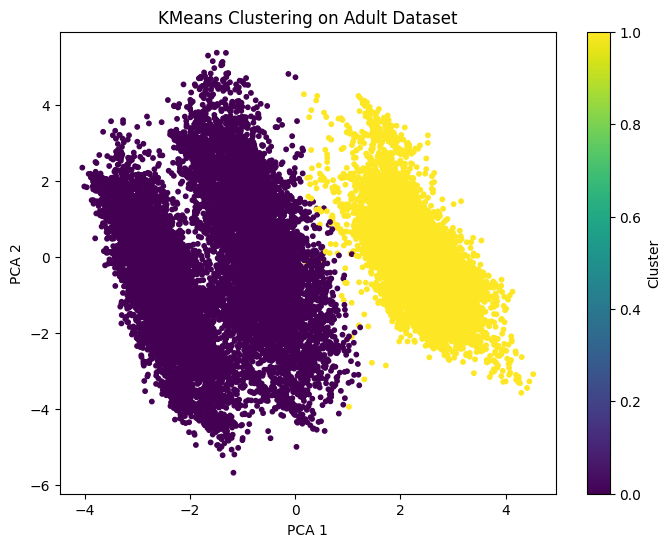

In [ ]:
# Standardisasi fitur agar memiliki mean=0 dan variance=1
# agar algoritma klaster dan PCA  tidak bias terhadap skala fitur
X_scaled = StandardScaler().fit_transform(X)

# melakukan PCA untuk mereduksi fitur menjadi 2 komponen utama agar mudah divisualisasikan
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# menerapkan KMeans clustering untuk membagi data menjadi 2 cluster
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Visualisasikan hasil PCA dan klaster KMeans
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=10)  # Titik diberi warna sesuai cluster
plt.title("KMeans Clustering on Adult Dataset")
plt.xlabel("PCA 1")  # Komponen PCA pertama
plt.ylabel("PCA 2")  # Komponen PCA kedua
plt.colorbar(label='Cluster')  # Tambahkan legenda warna cluster
plt.show()

In [ ]:
# melihat bobot bobot fitur dari komponen PCA
components = pd.DataFrame(
    np.round(pca.components_, 3),  # angka dibulatkan 3
    columns=X.columns,             # nama fitur
    index=['PCA1', 'PCA2']         # nama sumbu
)

# Tampilkan komponen (bobot kontribusi tiap fitur)
print(components.T.sort_values(by='PCA1', ascending=False))  # urutkan berdasarkan pengaruh terhadap PCA1

                                           PCA1   PCA2
relationship_mod_Husband                  0.433  0.041
marital.status_mod_Married-civ-spouse     0.413 -0.023
sex_mod_Male                              0.352  0.264
hours.per.week                            0.185 -0.083
age                                       0.185 -0.304
workclass_mod_Self-emp-not-inc            0.112 -0.098
occupation_mod_Craft-repair               0.106  0.132
workclass_mod_Self-emp-inc                0.094 -0.096
occupation_mod_Exec-managerial            0.077 -0.131
education.num                             0.064 -0.262
capital.gain                              0.063 -0.075
occupation_mod_Transport-moving           0.062  0.065
occupation_mod_Farming-fishing            0.057  0.030
capital.loss                              0.056 -0.051
occupation_mod_Protective-serv            0.036 -0.045
occupation_mod_Prof-specialty             0.029 -0.209
workclass_mod_Local-gov                   0.015 -0.192
workclass_

### Kesimpulan

Melalui pendekatan unsupervised learning dengan KMeans Clustering dan Principal Component Analysis (PCA), proyek ini berhasil mengidentifikasi dua kelompok utama dalam data tanpa menggunakan label penghasilan.

Hasil visualisasi dan bobot fitur menunjukkan bahwa data dapat dipisahkan secara jelas ke dalam dua cluster yang berbeda dimana PCA 1 memisahkan antara pria menikah yang bekerja banyak jam (nilai PCA 1 tinggi/positif)
vs perempuan, belum menikah, dan anak-anak dalam keluarga (nilai PCA 1 rendah/negatif). dan PCA 2 memisahkan antara Orang dewasa, pekerjaan lebih baik/terdidik, usia lebih tua (PCA 2 rendah/negatif) vs lajang, muda, pekerjaan kasar, anak sendiri (PCA 2 tinggi/positif)

Sehingga, clustering KMeans kemungkinan memisahkan antara kelompok dewasa menikah, bekerja penuh, berpenghasilan tinggi(**Warna Kuning**) vs Kelompok lebih muda, belum menikah atau anak tanggungan, dengan pekerjaan/jam kerja lebih rendah(**Warna Ungu**). Hal ini mengindikasikan adanya struktur alami dalam data yang mencerminkan perbedaan karakteristik sosial-ekonomi antar individu.

# *Supervised Learning*

## Load & Eksplorasi Data

## Preprocessing

### Kesimpulan

Karena Datasetnya masih sama, maka tidak perlu load,eksplorasi,dan preprocessing

### Feature Engineering

In [ ]:
# untuk kolom x sudah di definisikan sebelumnya pada K-means clustering
y = aci['income']  # Label (kolom target)


# Membagi Data Menjadi Train dan Test
# stratify digunakan untuk memastikan proporsi kelas tetap seimbang di test dan train
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# melakukan smote untuk membuat data sintetis pada kelas minoritas, agar data seimbang
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

'''
  neg, pos = np.bincount(y_train)
  scale_pos_weight = neg / pos'''

'\n  neg, pos = np.bincount(y_train)\n  scale_pos_weight = neg / pos'

## Modeling

In [ ]:
# Melakukan tuning hyperparameter agar mendapat hasil model yang baik
# Parameter grid/ daftar nilai hyparam yg mau diuji
param_grid = {
    'n_estimators': [300, 500],         # Jumlah pohon
    'max_depth': [5, 7, 9],             # Kedalaman maksimal tiap pohon
    'learning_rate': [0.03, 0.05, 0.1], # besar langkah tiap update bobot
    'subsample': [0.8, 1.0],            # Persentase data yang dipakai untuk tiap pohon
    'colsample_bytree': [0.8, 1.0],     # Persentase fitur (kolom) yang dipakai untuk tiap pohon
    'gamma': [0, 0.1],                  # Minimum pengurangan loss agar cabang dibuat(jika tinggi, model tdk mudah split)
    'reg_alpha': [0, 0.1],              # Membantu mengurangi overfitting dengan "menghukum" bobot besar
    'reg_lambda': [1, 1.5],             # sama dengan reg_alpha tetapi dengan cara kerja yang berbeda
    'min_child_weight': [1, 3],         # Minimum jumlah data di anak node(jika tinggi, pohon di model tdk mudah split)
}

In [ ]:
#  Membuat model XGBoost, menonaktifkan label encoder default dan memilih metric evaluasi logloss
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',tree_method='hist',random_state=42) # Membuat model XGboost Classifier dari library yang sudah diimpor sebelumnya dengan random state agar hasil konsisten

# Melakukan GridSearchCV untuk mencari dan memilih parameter terbaik(tuning)
random_search = RandomizedSearchCV(
    estimator=model,                # Model XGBoost
    param_distributions=param_grid, # daftar kombinasi parameter yang didefinisikan sblmnya
    n_iter=100,                     # Mencoba 100 kombinasi secara acak
    scoring='precision',            # Pilih model dengan precision terbaik
    cv=3,                           # Cross-validation 3 dengan  lipatan
    verbose=2,                      # Tampilkan progress
    random_state=42,                # agar bisa direproduksi
    n_jobs=-1                       # Menggunakan semua core CPU agar proses lebih cepat
)


# Melatih model dengan data training
random_search.fit(X_train_res, y_train_res)

# menyimpan model dengan kombinasi parameter terbaik dari hasil tuning
best_model = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
''' Inisialisasi threshold awal
best_thresh = 0.5
best_f1 = 0
for t in np.arange(0.3, 0.7, 0.01):
    y_pred_t = (proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best Threshold by F1: {best_thresh:.2f}")'''

' Inisialisasi threshold awal\nbest_thresh = 0.5\nbest_f1 = 0\nfor t in np.arange(0.3, 0.7, 0.01):\n    y_pred_t = (proba >= t).astype(int)\n    f1 = f1_score(y_test, y_pred_t)\n    if f1 > best_f1:\n        best_f1 = f1\n        best_thresh = t\n\nprint(f"Best Threshold by F1: {best_thresh:.2f}")'

In [ ]:
# Prediksi probabilitas pada setiap data di X_test yang termasuk ke dalam kelas 1 (positif)
proba = best_model.predict_proba(X_test)[:, 1]

# Threshold tuning(menggunakan nilai threshold sesuai dengan hasil kode di atas)
y_pred_final = (proba >= 0.57).astype(int)

# Evaluasi
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_final))

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      6790
           1       0.75      0.67      0.71      2252

    accuracy                           0.86      9042
   macro avg       0.82      0.80      0.81      9042
weighted avg       0.86      0.86      0.86      9042



AUC Score: 0.9222832527198864


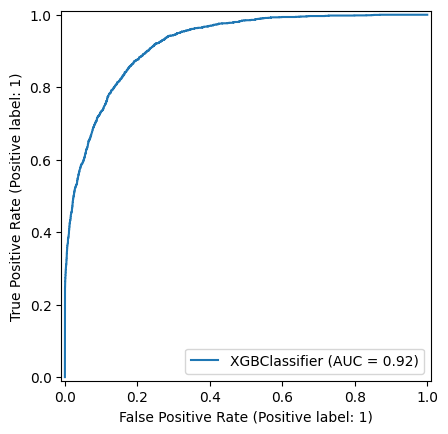

In [ ]:
# mengukur kemampuan model membedakan kelas 0 dan 1 (Area Under Curve)
print("AUC Score:", roc_auc_score(y_test, proba))

# membuat dan menampilkan kurva Receiver Operating Characteristic (ROC) dari model terbaik ke grafik.
RocCurveDisplay.from_estimator(best_model, X_test, y_test)

# grafik menunjukkan bahwa nilai AUC  : 0.92(model baik dalam membedakannya)
plt.show()

### Kesimpulan

Berdasarkan hasil evaluasi model dan pada gambar tersebut, diperoleh nilai akurasi sebesar 86%, yang menunjukkan bahwa model mampu mengklasifikasikan data dengan tingkat ketepatan yang cukup tinggi secara keseluruhan. Pada kelas mayoritas (label 0).

Sementara itu, untuk kelas minoritas (label 1), Meskipun precision cukup tinggi, recall yang lebih rendah menunjukkan bahwa masih terdapat sebagian data kelas 1 yang tidak berhasil dikenali oleh model.

Selain itu, nilai AUC (Area Under Curve) sebesar 0.92 menunjukkan bahwa model memiliki kemampuan diskriminatif yang sangat baik dalam membedakan antara kedua kelas

# Interpretasi & Insights

karakteristik pada dataset kali ini memiliki ketidakseimbangan kelas, di mana sebagian besar sampel berasal dari kelas penghasilan di bawah $50K (label 0). Hal ini juga diperkuat oleh hasil visualisasi menggunakan algoritma K-Means, yang menunjukkan dominasi klaster berwarna ungu yang merepresentasikan kelas tersebut.  Ketimpangan distribusi ini dapat menyebabkan model supervised learning cenderung bias terhadap kelas mayoritas dan mengabaikan kelas minoritas. sehingga diterapkan teknik SMOTE (Synthetic Minority Over-sampling Technique) pada data pelatihan agar model dapat lebih adil dalam mempelajari pola dari kedua kelas.

Model ini dioptimasi melalui proses tuning hyperparameter menggunakan metode RandomizedSearchCV yang dilakukan dengan mempertimbangkan berbagai kombinasi parameter penting, seperti jumlah pohon, kedalaman pohon, learning rate, dan parameter regularisasi, dengan tujuan untuk memaksimalkan nilai precision. Setelah diperoleh model terbaik, dilakukan penyesuaian threshold prediksi berdasarkan probabilitas, dengan menetapkan nilai ambang sebesar 0.57 sebagai batas klasifikasi akhir(sesuai percobaan hasil sebelumnya).

Model hasil akhir menghasilkan akurasi sebesar 86% dan AUC sebesar 0.92, yang menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam membedakan antara dua kelas tetapi masih kurang baik dalam mendeteksi kelas penghasilan tinggi akibat tumpang tindih karakteristik fitur antar kelas. karena memang sesuai dengan permasalahan sebelumnya. meskipun demikian, pencapaian ini merupakan hasil dari kombinasi strategi penyeimbangan data, optimasi parameter, serta penyesuaian threshod yang memberikan hasil yang baik dan sejalan dengan distribusi data aktual